In [200]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots
import ProgressMeter
using Random

import Base: show
import PDMats: PDMat

In [408]:
function hgf(n, iters, data)
    model = Model(DefaultMessageGate())
    
    xt_min_mean = add!(model, datavar(:xt_min_mean, Float64))
    xt_min_var  = add!(model, datavar(:xt_min_var, Float64))
    xt_min      = add!(model, randomvar(:xt_min))
    
    xt_min_prior = add!(model, make_node(NormalMeanVariance{Float64}, xt_min_mean, xt_min_var, xt_min))
    
    zt_min_mean = add!(model, datavar(:zt_min_mean, Float64))
    zt_min_var  = add!(model, datavar(:zt_min_var, Float64))
    zt_min      = add!(model, randomvar(:zt_min))
    
    zt_min_prior = add!(model, make_node(NormalMeanVariance{Float64}, zt_min_mean, zt_min_var, zt_min))
    
    zvar   = add!(model, constvar(:zvar, 1.0))
    zt     = add!(model, randomvar(:zt))
    
    z_transition = add!(model, make_node(NormalMeanVariance{Float64}, zt_min, zvar, zt))
    
    xt = add!(model, randomvar(:xt))
    kt = add!(model, constvar(:kt, 0.1))
    ωt = add!(model, constvar(:wt, 0.0))
    
    gcv = add!(model, make_node(GCV, xt_min, zt, kt, ωt, xt))
    
    y_var = add!(model, constvar(:y_var, 1.0))
    y     = add!(model, datavar(:y, Float64))
    
    obs = add!(model, make_node(NormalMeanVariance{Float64}, xt, y_var, y))
    
    activate!(model)
    
    # Prior marginals
    setmarginal!(gcv, :x_y, MvNormalMeanCovariance([ 0.0, 0.0 ], PDMat([ 5.0 0.0 ; 0.0 5.0 ])))
    setmarginal!(gcv, :z, NormalMeanVariance(0.0, 5.0))
    
    mz = Vector{NormalMeanVariance}()
    mx = Vector{NormalMeanVariance}()

    s_mz = subscribe!(getmarginal(zt), (t) -> push!(mz, getdata(t)))
    s_mx = subscribe!(getmarginal(xt), (t) -> push!(mx, getdata(t)))
    
    # Initial messages
    current_zt = NormalMeanVariance(0.0, 1.0)
    current_xt = NormalMeanVariance(0.0, 1.0)
    
    mz_out = Vector{NormalMeanVariance}(undef, n)
    mx_out = Vector{NormalMeanVariance}(undef, n)
    
    ProgressMeter.@showprogress for i in 1:n
        for _ in 1:iters
            update!(zt_min_mean, mean(current_zt))
            update!(zt_min_var, var(current_zt))
            update!(xt_min_mean, mean(current_xt))
            update!(xt_min_var, var(current_xt))
            update!(y, data[i])
        end
        
        current_zt = mz[end]
        current_xt = mx[end]
        
        mz_out[i] = current_zt
        mx_out[i] = current_xt
    end
    
    unsubscribe!(s_mz)
    unsubscribe!(s_mx)
    
    return mz_out, mx_out
end

hgf (generic function with 1 method)

In [409]:
n = 5000
iters = 25

Random.seed!(225)

real_k = 0.1
real_w = 0.0

z_prev     = 0.0
z_variance = 1.0

z = Vector{Float64}(undef, n)
for i in 1:n
    z[i] = rand(Normal(z_prev, sqrt(z_variance)))
    z_prev = z[i]
end

v = map(d -> exp(real_k * d + real_w), z)

x_prev = 0.0

x = Vector{Float64}(undef, n)

for i in 1:n
    x[i] = rand(Normal(x_prev, sqrt(v[i])))
    x_prev = x[i]
end

y = Vector{Float64}(undef, n)
y_var  = 1.0

for i in 1:n
    y[i] = rand(Normal(x[i], sqrt(y_var)))
end

In [410]:
@time mz, mx = hgf(n, iters, y);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


  2.570029 seconds (24.71 M allocations: 1.198 GiB, 16.79% gc time)


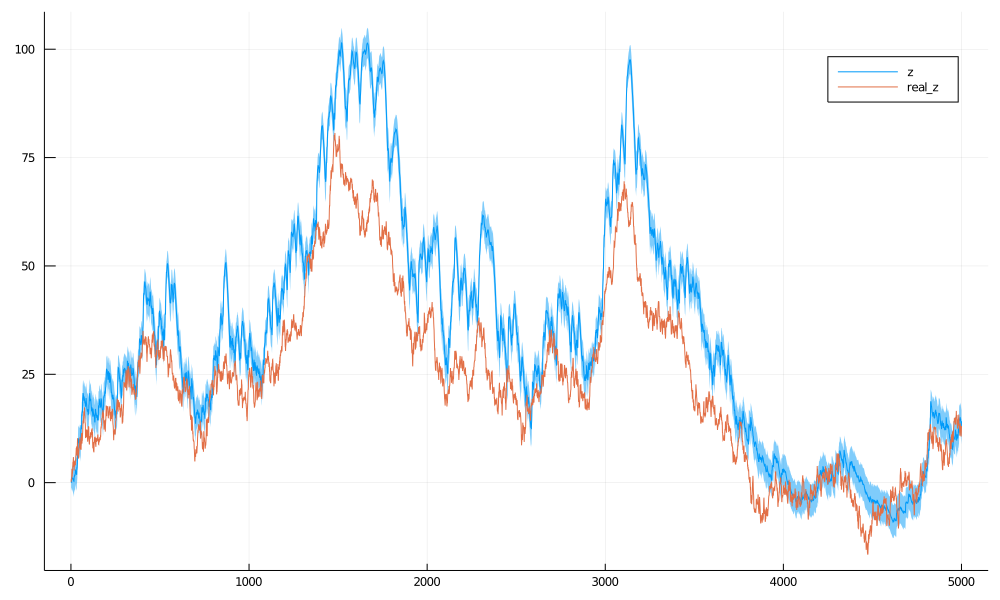

In [411]:
plot(mean.(mz), ribbon = std.(mz), label = :z, size = (1000, 600))
p1 = plot!(z, label = :real_z)

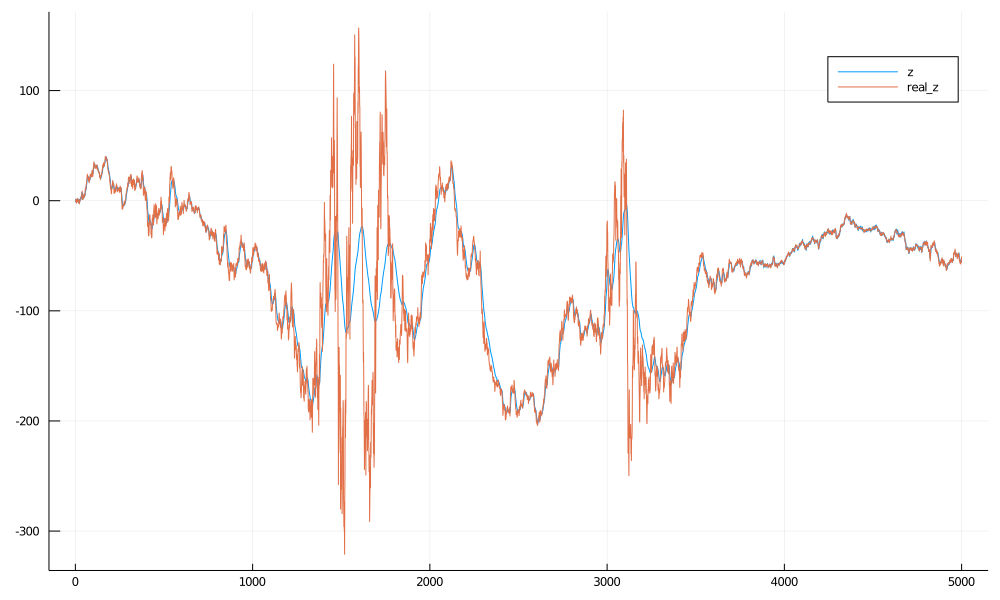

In [390]:
plot(mean.(mx), ribbon = std.(mx), label = :z, size = (1000, 600))
p1 = plot!(x, label = :real_z)